In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Read Historical Daily Yen Futures Data
In this notebook, you will load historical Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


 # Return Forecasting: Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'Settle Price'}, xlabel='Date'>

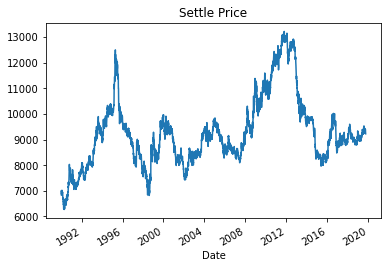

In [4]:
# Plot just the "Settle" column from the dataframe:
yen_futures["Settle"].plot(title='Settle Price')

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the "Settle" price into two separate series:

ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures['Settle'])

In [6]:
# Create a dataframe of just the settle price, and add columns for "noise" and "trend" series from abov

hodrick_df =pd.DataFrame(yen_futures['Settle'])
hodrick_df['noise'] = ts_noise
hodrick_df['trend'] = ts_trend

<AxesSubplot:title={'center':'Settle Price Noise VS Trend'}, xlabel='Date'>

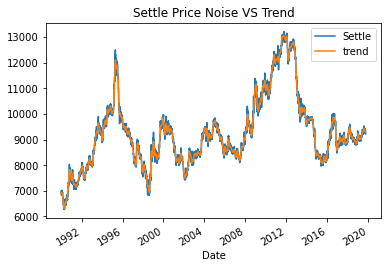

In [7]:
# Plot the Settle Price vs. the Trend for 2015 to the present
hodrick_df.drop(columns='noise').plot(title='Settle Price Noise VS Trend')

<AxesSubplot:title={'center':'Settle Price Noise'}, xlabel='Date'>

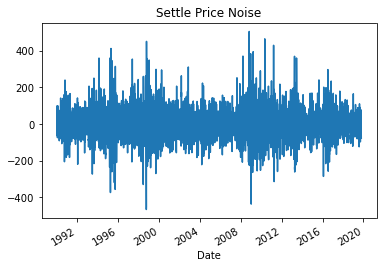

In [8]:
# Plot the Settle Noise

hodrick_df['noise'].plot(title='Settle Price Noise')

---

# Forecasting Returns using an ARMA Model

Using futures Settle *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARIMA(returns['Settle'], order=(2, 0, 1))


# Fit the model and assign it to a variable called results
res = model.fit()

/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: Us

In [11]:
# Output model summary results:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -7894.080
Date:                Wed, 29 Sep 2021   AIC                          15798.159
Time:                        17:43:33   BIC                          15832.782
Sample:                             0   HQIC                         15810.047
                               - 7514                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.774      0.439      -0.010       0.022
ar.L1         -0.0058     19.628     -0.000      1.000     -38.476      38.465
ar.L2         -0.0004      0.229     -0.002      0.999      -0.449       0.448
ma.L1         -0.0058     19.627     -0.000      1.000     -38.475      38.463
sigma2         0.4787      0.004    123.831      0.000       0.471       0.486
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17209.44
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
type(res)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:title={'center':'Five Day Returns Forcast'}>

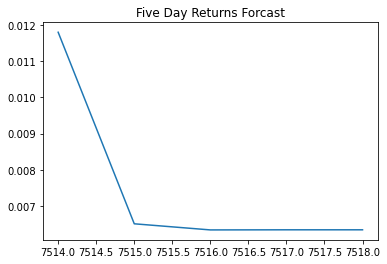

In [13]:
# Plot the 5 Day Returns Forecast
res.forecast(5).plot(title='Five Day Returns Forcast')

---

# Forecasting the Settle Price using an ARIMA Model

 1. Using the *raw* Yen **Settle Price**, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Estimate and ARIMA Model:
model = ARIMA(returns['Settle'], order=(5, 1, 1))

# Fit the model
res= model.fit()

/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [15]:
# Output model summary results:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -7895.995
Date:                Wed, 29 Sep 2021   AIC                          15805.989
Time:                        17:43:41   BIC                          15854.460
Sample:                             0   HQIC                         15822.632
                               - 7514                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0118      0.008     -1.415      0.157      -0.028       0.005
ar.L2         -0.0005      0.009     -0.050      0.960      -0.018       0.017
ar.L3         -0.0129      0.010     -1.355      0.175      -0.032       0.006
ar.L4         -0.0192      0.010     -1.954      0.051      -0.039    6.15e-05
ar.L5         -0.0022      0.010     -0.224      0.822      -0.021       0.017
ma.L1         -1.0000      0.010   -100.893      0.000      -1.019      -0.981
sigma2         0.4785      0.007     73.453      0.000       0.466       0.491
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17151.11
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.65
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
type(res.forecast(5))

/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


pandas.core.series.Series

/Users/krbyland/opt/anaconda3/envs/dev/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


<AxesSubplot:title={'center':'Five Day Price Forcast'}>

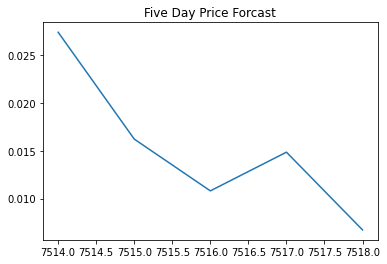

In [17]:
# Plot the 5 Day Price Forecast
res.forecast(5).plot(title='Five Day Price Forcast')

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen futures returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using futures Settle *Returns*, estimate an GARCH model

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [18]:
from arch import arch_model

In [23]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

# Fit the model
arch_res = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 7907.752569069989
Iteration:      2,   Func. Count:     10,   Neg. LLF: 7499.999539388455
Iteration:      3,   Func. Count:     15,   Neg. LLF: 7526.127796070408
Iteration:      4,   Func. Count:     20,   Neg. LLF: 7507.683271628448
Iteration:      5,   Func. Count:     25,   Neg. LLF: 7492.0881461035715
Iteration:      6,   Func. Count:     30,   Neg. LLF: 7502.09587155129
Iteration:      7,   Func. Count:     35,   Neg. LLF: 12576.142075672902
Iteration:      8,   Func. Count:     41,   Neg. LLF: 7462.596857255197
Iteration:      9,   Func. Count:     46,   Neg. LLF: 7462.263687846594
Iteration:     10,   Func. Count:     51,   Neg. LLF: 7461.927648765221
Iteration:     11,   Func. Count:     55,   Neg. LLF: 7461.927640083815
Iteration:     12,   Func. Count:     58,   Neg. LLF: 7461.927640081942
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7461.927640083815
            Iterations: 12


In [24]:
# Summarize the model results
arch_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                 Settle   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7461.93
Distribution:                  Normal   AIC:                           14929.9
Method:            Maximum Likelihood   BIC:                           14950.6
                                        No. Observations:                 7514
Date:                Wed, Sep 29 2021   Df Residuals:                     7511
Time:                        17:44:02   Df Model:                            3
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      4.2895e-03  1.798e-03      2.385  1.707e-02 [7.646e-04,7.814e-03]
alpha[1]       0.0381  8.773e-03      4.341  1.419e-05 [2.089e-02,5.528e-02]
beta[1]        0.9536  1.114e-02     85.623      0.000     [  0.932,  0.975]
============================================================================

Covariance estimator: robust
"""

In [25]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2019-10-15'

In [27]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = arch_res.forecast(horizon=forecast_horizon)
forecasts

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
# Plot the final forecast
final.plot(title='Final Forcast')

---

# Conclusions

### Based on your time series analysis, would you buy the yen now?

No, it is tanking.

### Is the risk of the yen expected to increase or decrease?

According to my chart, the volatily is going to increase so the risk increases.

### Based on the model evaluation, would you feel confident in using these models for trading?

No, after comparing it to my classmates, our numbers are different 